<span style = "color:Red ;font-size:30px" > **Underdamped Second-Order System**</span>

# Problem Overview

In this assignment, I solved the **differential equation for the unit step input response** given by:

$$
\frac{d^2 y(t)}{dt^2} + 2\zeta\omega_n \frac{dy(t)}{dt} + \omega_n^2 y(t) = \omega_n^2 u(t)
$$

### Initial Conditions:
- \( y(0) = 0 \)
- \( \frac{dy(0)}{dt} = 0 \)

### Damping Ratio:
For the underdamped case, the damping ratio is defined as:

$$
0 < \zeta < 1
$$

The damped natural frequency is expressed as:

$$
\omega_d = \omega_n \sqrt{1 - \zeta^2}
$$

### Analytical Solution:
The analytical solution to this differential equation is given by:

$$
y(t) = 1 - \frac{e^{-\zeta \omega_n t}}{\sqrt{1 - \zeta^2}} \sin\left( \omega_d t + \phi \right)
$$

where

$$
\phi = \arccos(\zeta)
$$

### Definitions:
- \( y(t) \): The output or response of the system.
- \( u(t) \): The input function, which is the unit step function for this case (i.e., \( u(t) = 1 \) for \( t \geq 0 \)).
- \( \omega_n \): The natural frequency of the system.
- \( \zeta \): The damping ratio.

In [ ]:
#Importing all required libraries
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#Defining analytical soluion to my problem with code
def linear_time_invariant_system(d,Wn,x):
    assert 0<d<1
    Wd = Wn*(np.sqrt(1-d**2))
    phi = np.arccos(d)
    A = np.sqrt(1-d**2)
    sin = torch.sin(phi + Wd*x)
    exp = torch.exp(-d*Wn*x)
    y = 1-1/A*(exp*sin)
    return y


In [ ]:
#Defining class Fn to get a solution through neural netwok
#I used 2 hidden layers and 3 neural layers.
class Fn(nn.Module):

    def __init__(self,n_input,n_output,n_hidden,n_layer):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_input,n_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden,n_hidden),
                            activation()]) for _ in range(n_layer -1)])
        self.fce = nn.Linear(n_hidden,n_output)

    def forward(self,x):   #forward pass
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)

        return x

<span style = "font-size :30px" >**Generating Training Data**</span>

torch.Size([9000, 1]) torch.Size([9000, 1])
torch.Size([100, 1]) torch.Size([100, 1])


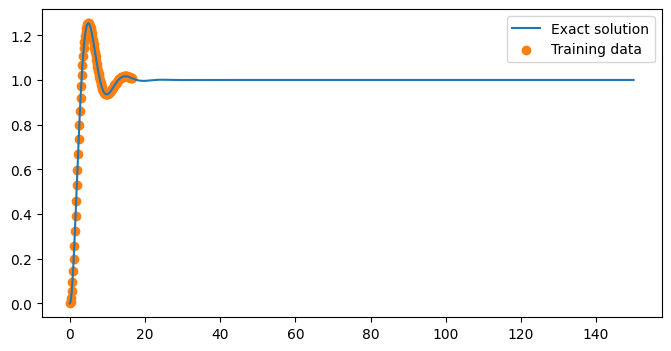

In [ ]:
d,Wn = 0.4,.7 #most common case


x = torch.linspace(0,150,9000).view(-1,1)
y = linear_time_invariant_system(d,Wn,x).view(-1,1)#analytical solution over full domain
print(x.shape,y.shape)

#slicing out points
x_data = x[0:1000:10]
y_data = y[0:1000:10]
print(x_data.shape, y_data.shape)

plt.figure(figsize = (8,4))
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

<span style = "font-size:30px"> **Normal Neural Network**</span>

Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

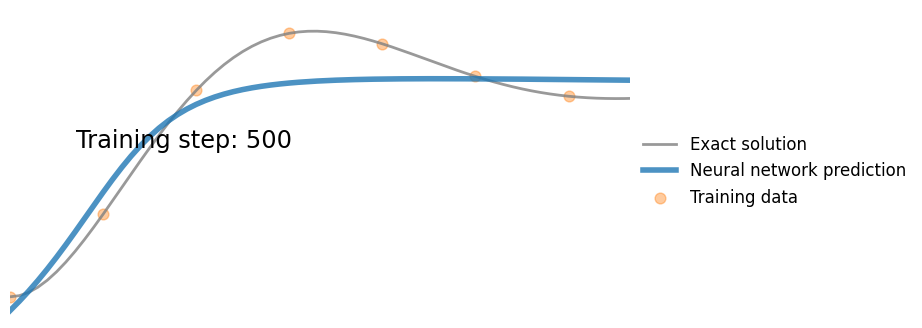

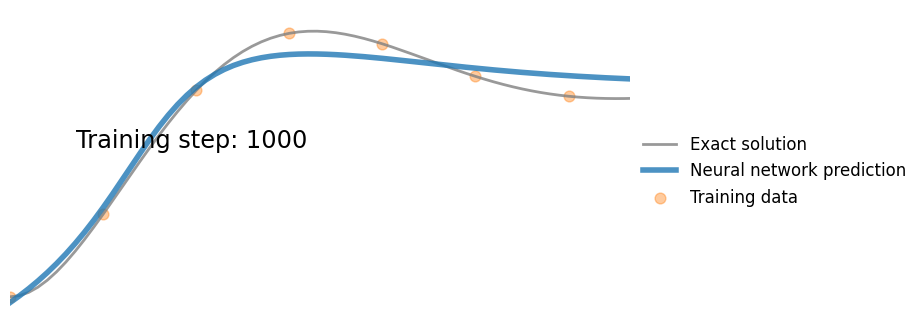

In [ ]:
def plot_result(x,y,x_data,y_data,yp,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yp, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.xlim(-0.05, 1.05)
    # plt.ylim(-1.1, 1.1)
    plt.xlim(0, 10)  # Adjusting x-limits according to the time range
    y_min, y_max = y.min().item(), y.max().item()
    plt.ylim(y_min - 0.1, y_max + 0.1)  # Dynamically adjusting y-limits
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# Training standard data
torch.manual_seed(150)

model = Fn(1,1,25,4)
optimizer = torch.optim.Adam(model.parameters(),lr = .001)
#Itried different learning rates, and then decide to keep it 0.005,
files = []

for i in range(1000):
    optimizer.zero_grad()
    yp = model(x_data)
    loss1 = torch.mean((yp - y_data)**2)
    loss1.backward()
    optimizer.step()


    #plotting result
    if (i+1) % 10 ==0:
        yp = model(x).detach()
        plot_result(x,y,x_data,y_data,yp)
        file = "plots/nn_%.8i.png"%(i+1)
        files.append(file)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")


Here from graph it is easily visible that our predicted answers using neural network are only correct upto initial iterations, later on it start giving wrong predictions.
So here our normal neural network fails.

<span style = "font-size:30px"> **Using Physics Informed Neural Network**</span>

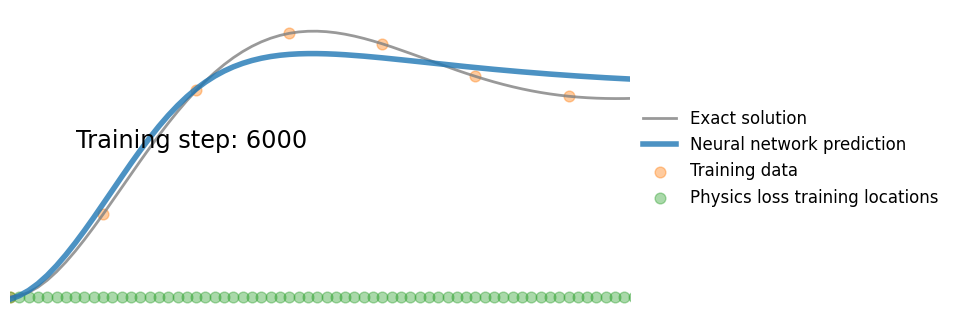

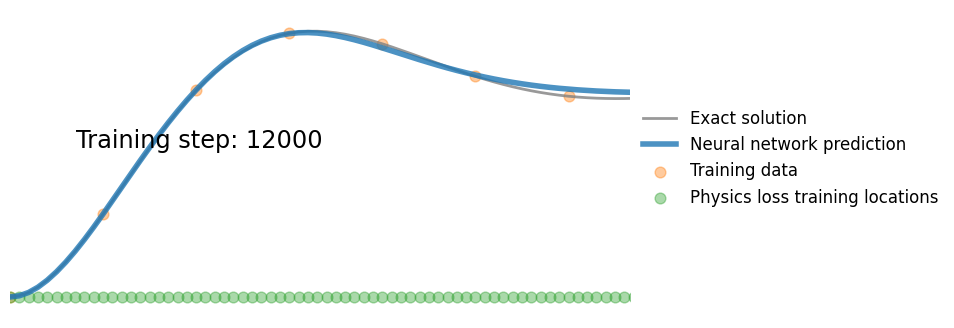

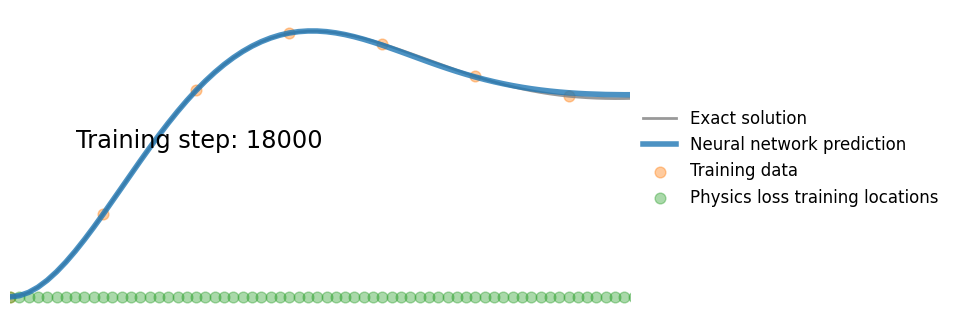

In [ ]:
#Now we will perform the same task with adding physics loss to our training loss.
# torch.manual_seed(123)
x_physics = torch.linspace(0, 150, 1000).view(-1, 1).requires_grad_(True)
u = torch.where(x_physics >= 0, torch.ones_like(x_physics), torch.zeros_like(x_physics))

torch.manual_seed(123)


model = Fn(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

files = []
for i in range(20000):
    optimizer.zero_grad()
    yp = model(x_data)
    loss1 = torch.mean((yp - y_data)**2)


    #compute physics loss
    yhp = model(x_physics)
    dy/dx = torch.autograd.grad(yhp,x_physics, torch.ones_like(yhp), create_graph =True)[0]
    d2y/dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph = True)[0]
    physics = d2y/dx2 + 2*d*Wn*dy/dx + Wn**2*yhp - Wn**2*u
    loss2 = torch.mean(physics**2)

    #backpropagate joint loss
    loss = loss1 + loss2 #adding physics loss to data loss.
    loss.backward()
    optimizer.step()

    #plot
    if (i+1) %200 ==0:
        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

As one can observe easily from graph that our predicted solution and actual solution are the same.Thats the reason PINN is used.

<span style = "color:red ;font-size:20px" > **Inference :-** </span> We found that when we use normal neural network to solve the diffferential equation, the solutions were not that accurate and also not reliable at the same time.
So we introdeuced physics informed neural networks, which deals with the problem of accuracy and relevancy as we add physics loss into the equation.


<span style = "color:blue ;font-size:25px" > **References :-** </span></br>
<span style = "color:red ;font-size:15px" > **1. Original paper :-** </span>- Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations
</br><span style = "color:red ;font-size:15px" > **2. Video by Steve Brunton :-** </span>"https://www.youtube.com/watch?v=-zrY7P2dVC4".
</br><span style = "color:red ;font-size:15px" > **3.** </span> Course notes from Basic Electrical Engineering, 2nd Semester(helped in finding the perfect differential equation).